In [1]:
import matplotlib.pyplot as plt
import pywt
import numpy as np

from tabulated_wvt import TabulatedFunc, TabulatedWavelet
from wvt_basis_manager import WaveletBasisManager

array([ 5.25491451e-06, -2.94702274e-06, -1.92502630e-05, -4.32259375e-05,
       -7.28663192e-05, -9.77267371e-05, -6.26277789e-05,  2.91741096e-04,
        1.97461583e-03,  8.12473484e-03,  2.63410723e-02,  7.06330203e-02,
        1.60401390e-01,  3.15820139e-01,  5.52913226e-01,  8.81867487e-01,
        1.30852028e+00,  1.83681884e+00,  2.47079913e+00,  3.21584867e+00,
        4.07945454e+00,  5.07158836e+00,  6.20473686e+00,  7.49348310e+00,
        8.95350260e+00,  1.05998521e+01,  1.24445036e+01,  1.44931998e+01,
        1.67418571e+01,  1.91728790e+01,  2.17518315e+01,  2.44249369e+01,
        2.71177184e+01,  2.97347736e+01,  3.21601948e+01,  3.42395665e+01,
        3.59604365e+01,  3.62788763e+01,  3.93312508e+01,  3.91508881e+01])

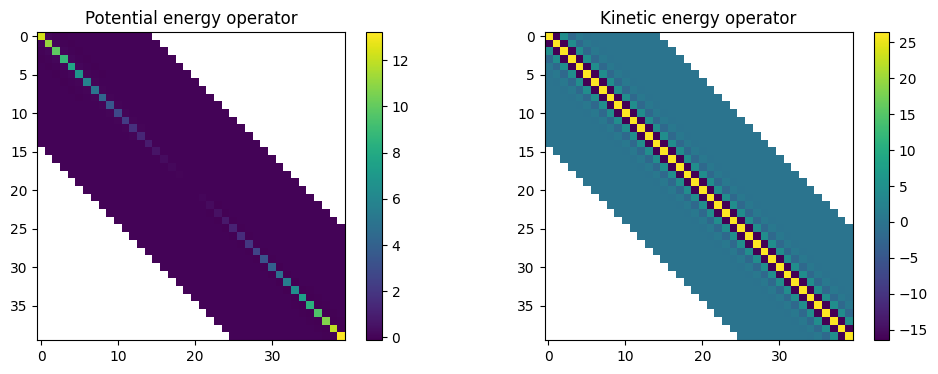

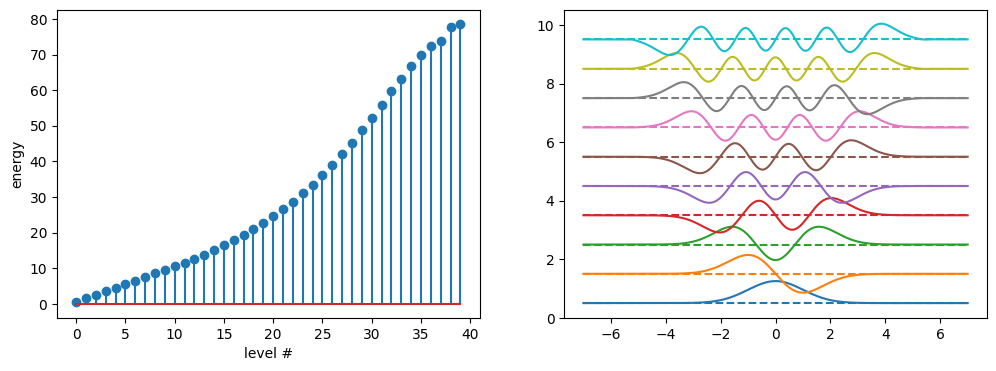

In [2]:
def experiment(
    wvt_name="sym8",
    lims=(-7, 7),
    nsteps=40,
    level=5,
    use_subscale=False,
    do_plots=True,
    plot_levels=10,
    potential_grid_step=0.01,
):
    wvt = pywt.Wavelet(wvt_name)
    wvt_man = WaveletBasisManager(TabulatedWavelet(wvt), nsteps, lims, level, use_subscale)
    basis_size = len(wvt_man.basis_funcs)

    xx = np.linspace(*lims, np.ceil((lims[1] - lims[0]) / 0.01).astype(int))
    potential = TabulatedFunc(xx, xx**2 / 2)

    V_mat = np.zeros((basis_size, basis_size))
    T_mat = np.zeros((basis_size, basis_size))
    for i, j in wvt_man.iterate_overlapping_ids():
        V_mat[i, j] = V_mat[j, i] = (wvt_man.basis_funcs[i] * wvt_man.basis_funcs[j] * potential).int().yy[-1]
        T_mat[i, j] = T_mat[j, i] = ((-0.5) * wvt_man.basis_funcs[i] * wvt_man.basis_funcs[j].der().der()).int().yy[-1]

    if do_plots:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(np.ma.masked_array(V_mat, V_mat == 0))
        plt.colorbar()
        plt.title("Potential energy operator")
        plt.subplot(1, 2, 2)
        plt.imshow(np.ma.masked_array(T_mat, T_mat == 0))
        plt.colorbar()
        plt.title("Kinetic energy operator")

    H_mat = V_mat + T_mat
    energies, states = np.linalg.eigh(H_mat)
    eigh_error = np.abs(H_mat @ states - states * energies[None, :]).max()
    if eigh_error > 1e-8:
        print("Warning: eigh error =", eigh_error)

    if do_plots:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.stem(energies)
        plt.xlabel("level #")
        plt.ylabel("energy")

        plt.subplot(1, 2, 2)
        for n in range(plot_levels):
            result_func = wvt_man.reconstruct(states[:, n]) + energies[n]
            line, = result_func.plot();
            plt.plot([result_func.xx[0], result_func.xx[-1]], [energies[n], energies[n]], "--", color=line.get_color())
        plt.ylim(bottom=0);

    return energies - (np.arange(len(energies)) + 0.5)

experiment()

array([ 5.25396878e-06, -2.96225531e-06, -1.93726742e-05, -4.38850512e-05,
       -7.55606731e-05, -1.06709524e-04, -8.82551786e-05,  2.26883827e-04,
        1.82473858e-03,  7.80109711e-03,  2.56773994e-02,  6.93282620e-02,
        1.57926673e-01,  3.11261808e-01,  5.44704304e-01,  8.67346317e-01,
        1.28324835e+00,  1.79358760e+00,  2.39826433e+00,  3.09676042e+00,
        3.88851133e+00,  4.77303702e+00,  5.74996977e+00,  6.81904468e+00,
        7.98008421e+00,  9.23299479e+00,  1.05777887e+01,  1.20146391e+01,
        1.35439695e+01,  1.51665636e+01,  1.68836710e+01,  1.86970705e+01,
        2.06090624e+01,  2.26223823e+01,  2.47400617e+01,  2.69652867e+01,
        2.93013036e+01,  3.17513995e+01,  3.43189569e+01,  3.70075579e+01,
        3.98211086e+01,  4.27639553e+01,  4.58409743e+01,  4.90576237e+01,
        5.24199535e+01,  5.59345730e+01,  5.96085749e+01,  6.34494182e+01,
        6.74647651e+01,  7.16622682e+01,  7.60492963e+01,  8.06325908e+01,
        8.54178448e+01,  

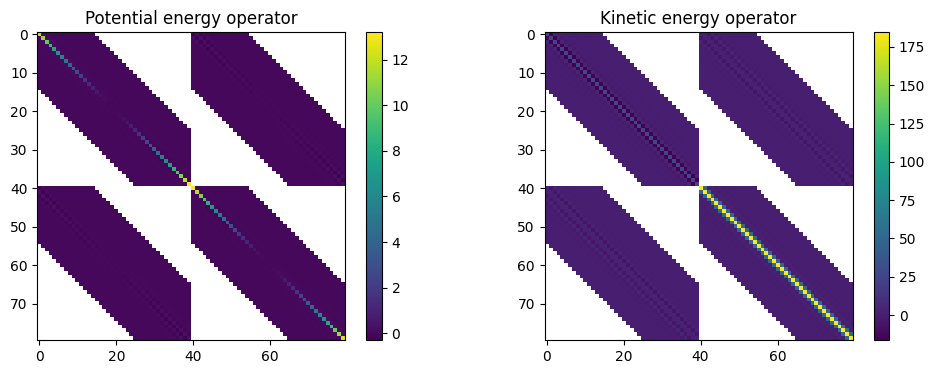

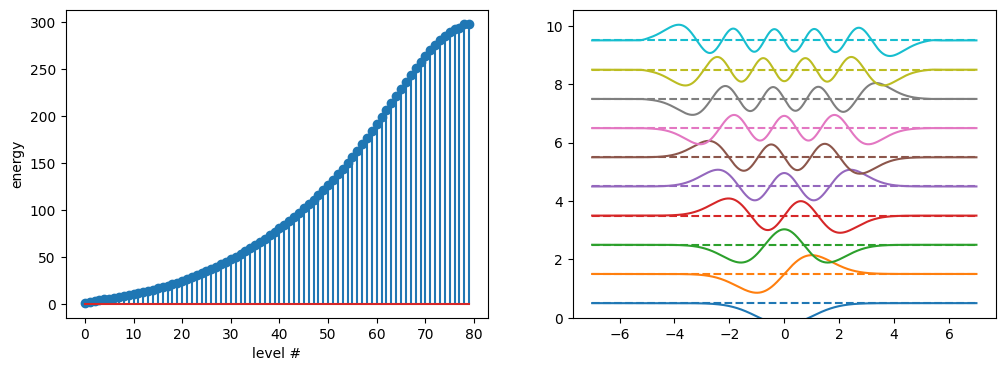

In [3]:
experiment(use_subscale=True)

In [4]:
def mae(errors):
    return np.abs(errors[:6]).mean()

ranges = np.arange(4, 15, 0.5)
num_steps = [6, 10, 15, 20, 30, 40, 60, 80, 120, 160]

quality_nosubs = np.ones((len(ranges), len(num_steps))) * 999.0
quality_subs = np.ones((len(ranges), len(num_steps))) * 999.0
for i_r, r in enumerate(ranges):
    print(f"range = {r}", flush=True)
    for i_s, s in enumerate(num_steps):
        quality_nosubs[i_r, i_s] = mae(experiment(lims=(-r, r), nsteps=s, do_plots=False))
        quality_subs[i_r, i_s] = mae(experiment(lims=(-r, r), nsteps=s, do_plots=False, use_subscale=True))

range = 4.0
range = 4.5
range = 5.0
range = 5.5
range = 6.0
range = 6.5
range = 7.0
range = 7.5
range = 8.0
range = 8.5
range = 9.0
range = 9.5
range = 10.0
range = 10.5
range = 11.0
range = 11.5
range = 12.0
range = 12.5
range = 13.0
range = 13.5
range = 14.0
range = 14.5


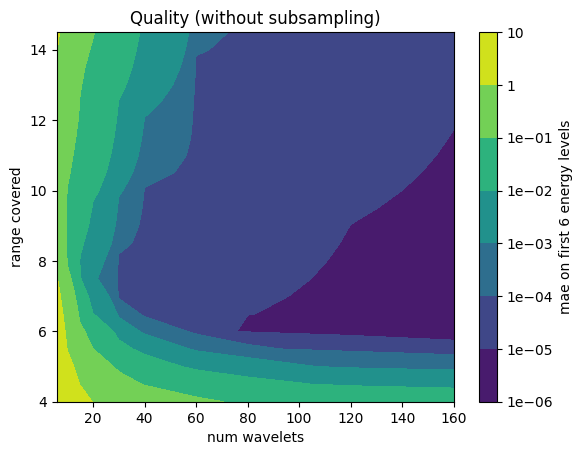

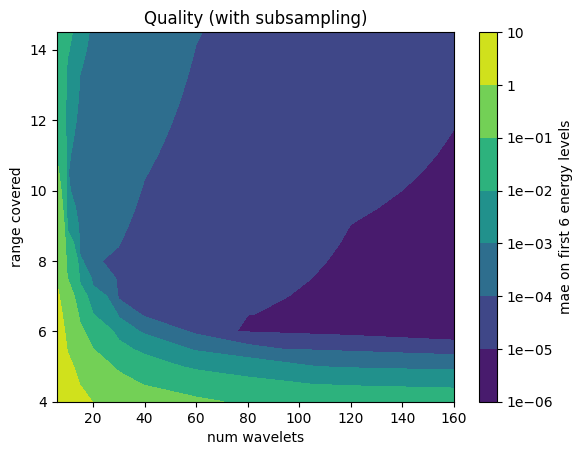

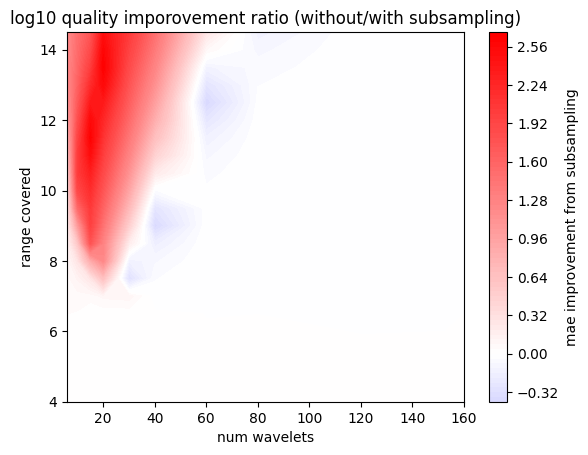

In [7]:
import matplotlib as mpl

plt.figure()
plt.contourf(num_steps, ranges, quality_nosubs, norm=mpl.colors.LogNorm(), levels=100)
plt.colorbar(format=mpl.ticker.LogFormatter(), label="mae on first 6 energy levels")
plt.xlabel("num wavelets")
plt.ylabel("range covered")
plt.title("Quality (without subsampling)")

plt.figure()
plt.contourf(num_steps, ranges, quality_subs, norm=mpl.colors.LogNorm(), levels=100)
plt.colorbar(format=mpl.ticker.LogFormatter(), label="mae on first 6 energy levels")
plt.xlabel("num wavelets")
plt.ylabel("range covered")
plt.title("Quality (with subsampling)")

plt.figure()
log10_ratio = np.log10(quality_nosubs / quality_subs)
vmax = np.abs(log10_ratio).max()
plt.contourf(num_steps, ranges, log10_ratio, levels=100, cmap="bwr", vmin=-vmax, vmax=vmax)
plt.colorbar(label="mae improvement from subsampling")
plt.xlabel("num wavelets")
plt.ylabel("range covered")
plt.title("log10 quality imporovement ratio (without/with subsampling)");

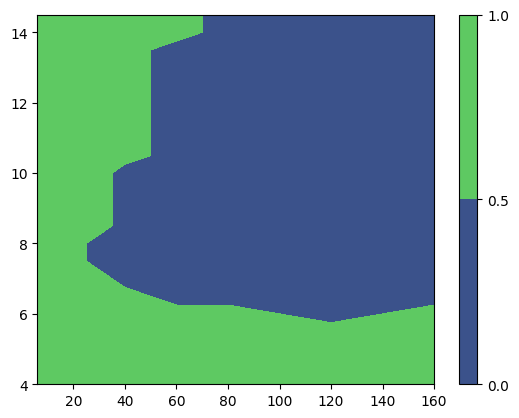

In [9]:
plt.contourf(num_steps, ranges, quality_subs <= quality_nosubs, levels=[0, 0.5, 1]);
plt.colorbar();